# Athens University of Economics and Business
# MSc in Business Analytics
# Machine Learning & Content Analytics  
# Argument Detection
# Group 6
---
## Team Members: 
> ### MSc Student 1: Agapiou Marios  (f2821901)           

> ### MSc Student 2: Kontos Christos  (f2821906)

> ### MSc Student 3: Skarlis Vasileios (f2821912)

#   Data Parsing

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: argument/
  inflating: argument/ABC_G1B1_10.1016 j.energy.2010.09.041.csv  
  inflating: argument/ABC_G1B1_10.1016 j.energy.2013.10.051.csv  
  inflating: argument/ABC_G1B1_10.1016 j.enpol.2012.03.053.csv  
  inflating: argument/ABC_G1B1_10.1016 j.jclepro.2019.119080.csv  
  inflating: argument/ABC_G1B1_10.1016 j.jclepro.2019.119122.csv  
  inflating: argument/ABC_G1B1_10.1016 j.jclepro.2019.119260.csv  
  inflating: argument/ABC_G1B1_10.1016 j.mcm.2012.09.006.csv  
  inflating: argument/ABC_G1B1_10.1016_0360-3199(93)90115-Q.csv  
  inflating: argument/ABC_G1B1_10.1016_j.apenergy.2019.01.154.csv  
  inflating: argument/ABC_G1B1_10.1016_j.atmosenv.2014.08.064.csv  
  inflating: argument/ABC_G1B1_10.1016_j.energy.2018.11.091.csv  
  inflating: argument/ABC_G1B1_10.1016_j.enpol.2011.02.062.csv  
  inflating: argument/ABC_G1B1_10.1016_j.enpol.2011.07.032.csv  
  inflating: argument/ABC_G1B1_10.1016_j.enpol.2013.09.061.csv  
  inflating: argument/ABC_G1B1_

In [ ]:
# import all the necessary modules for the implementation of our project

from nltk.tokenize import sent_tokenize
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.python.keras.preprocessing.text import Tokenizer
import re
import collections as co
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from pprint import pprint
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
nltk.download('stopwords')

import statistics
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class ArgumentParser:
    
    # Get the list of all the file paths
    @staticmethod
    def get_argument_files():
        return list(Path('argument').glob('**/*.csv'))
    
    # Read each csv and append the lines in the list frames
    def setup_without_context(self):
        files = self.get_argument_files()
        frames = list()
    
        # For each file save the sentences and the label 
        for file_path in tqdm(files):
            df = pd.read_csv(file_path)
            df['label'] = df['label'].str.strip()
            df['label'].replace('_', 'NO LABEL', inplace=True)
            df['label'].replace('Missing', 'NO LABEL', inplace=True)
            df['label'] = df['label'].str.strip().str.upper()

            frames.append(df)
        # Return the final dictionary with the dataframe and the colums
        data = pd.concat(frames).reset_index(drop=True)
        return {'X': data['sentence'].tolist(),
                'y': data['label'].tolist(),
                'df': data}


if __name__ == "__main__":
    parser = ArgumentParser()

    swc_doc = parser.setup_without_context()
    pprint(swc_doc['X'][:5])
    pprint(swc_doc['y'][:5])
    print(swc_doc['df']['label'].value_counts())
    print(swc_doc['df'])

100%|██████████| 889/889 [00:04<00:00, 198.65it/s]


['“Green” consumption—no solution for climate change',
 'Abstract: This article explores the quantitative effect on energy use and '
 'carbon dioxide (CO2) emissions if households were to adopt “green” '
 'consumption patterns.',
 'It shows that green consumption patterns generally reduce energy consumption '
 'and CO2 emissions.',
 'The reductions are, however, small and one experiment even shows that the '
 'adoption of a partly green consumption pattern may increase total emissions.',
 'The major conclusion is that adopting green patterns of consumption while '
 'retaining the same level of total consumption does not solve the problem of '
 'climate change (CO2 emission), but could at best offer a temporary '
 'palliative.']
['NO LABEL', 'NO LABEL', 'NO LABEL', 'EVIDENCE', 'CLAIM']
NO LABEL    8588
EVIDENCE    1486
CLAIM        990
Name: label, dtype: int64
          label                                           sentence
0      NO LABEL  “Green” consumption—no solution for climate

In [ ]:
# Get a first look of the dataset

swc_doc['df'].head(10)

,label,sentence
0,NO LABEL,“Green” consumption—no solution for climate ch...
1,NO LABEL,Abstract: This article explores the quantitati...
2,NO LABEL,It shows that green consumption patterns gener...
3,EVIDENCE,"The reductions are, however, small and one exp..."
4,CLAIM,The major conclusion is that adopting green pa...
5,NO LABEL,﻿Eradicating female genital mutilation and cut...
6,NO LABEL,BackgroundFemale genital mutilation and cuttin...
7,NO LABEL,The practice is still prevalent in 29 countrie...
8,NO LABEL,The approaches for eradication have been multi...
9,NO LABEL,"A household survey, key informant interviews, ..."


In [ ]:
# find the actual percentages of the labels

nrows = swc_doc['df'].shape[0]
perc=(swc_doc['df'].groupby(['label']).size() / nrows) * 100 
round(perc,2).astype(str) + '%'

label
CLAIM        8.95%
EVIDENCE    13.43%
NO LABEL    77.62%
dtype: object

In [ ]:
# find the cumulative results of the labels

swc_doc['df'].groupby(['label']).size()

label
CLAIM        990
EVIDENCE    1486
NO LABEL    8588
dtype: int64

In [ ]:
# Check for missing values

swc_doc['df'].isna().sum()

label       0
sentence    0
dtype: int64

In [ ]:
# Calculate the main statistical results

swc_doc['df'].describe().T

,count,unique,top,freq
label,11064,3,NO LABEL,8588
sentence,11064,10403,Abstract,171


In [ ]:
# Remove duplicate rows

swc_doc['df'].drop_duplicates(subset ="sentence", keep = 'first', inplace = True)
swc_doc['df'] = swc_doc['df'].reset_index(drop=True)
swc_doc['df']

,label,sentence
0,NO LABEL,“Green” consumption—no solution for climate ch...
1,NO LABEL,Abstract: This article explores the quantitati...
2,NO LABEL,It shows that green consumption patterns gener...
3,EVIDENCE,"The reductions are, however, small and one exp..."
4,CLAIM,The major conclusion is that adopting green pa...
...,...,...
10398,NO LABEL,In the current study we have used English pane...
10399,NO LABEL,This allowed us to control for both time-invar...
10400,EVIDENCE,"In support of cross-sectional analysis, indivi..."
10401,NO LABEL,No coastal effect on life satisfaction was found.


In [ ]:
# take again a quick view of the dataset

swc_doc['df'][['label','sentence']]

,label,sentence
0,NO LABEL,“Green” consumption—no solution for climate ch...
1,NO LABEL,Abstract: This article explores the quantitati...
2,NO LABEL,It shows that green consumption patterns gener...
3,EVIDENCE,"The reductions are, however, small and one exp..."
4,CLAIM,The major conclusion is that adopting green pa...
...,...,...
10398,NO LABEL,In the current study we have used English pane...
10399,NO LABEL,This allowed us to control for both time-invar...
10400,EVIDENCE,"In support of cross-sectional analysis, indivi..."
10401,NO LABEL,No coastal effect on life satisfaction was found.


<Figure size 864x720 with 0 Axes>

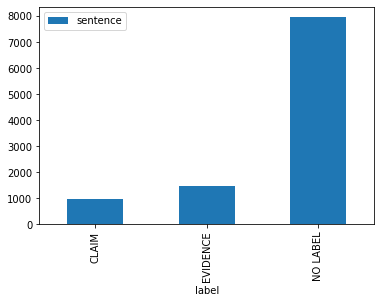

In [ ]:
# Visualize the results

fig = plt.figure(figsize=(12,10))
swc_doc['df'].groupby('label').count().plot.bar(ylim=0)
plt.show()

In [ ]:
# Extraction of the most common characteristics of the sentences

swc_fed = swc_doc['df']

#words count
swc_fed['word_count'] = swc_fed['sentence'].apply(lambda x: len(str(x).split(" "))) 

#number of characters. This also includes spaces
swc_fed['char_count'] = swc_fed['sentence'].str.len() 

#average word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))
swc_fed['avg_word'] = swc_fed['sentence'].apply(lambda x: avg_word(x)) 

#number of stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
swc_fed['stopwords'] = swc_fed['sentence'].apply(lambda x: len([x for x in x.split() if x in stop])) 

#number of special characters
swc_fed['hastags'] = swc_fed['sentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')])) 

#number of numerics
swc_fed['numerics'] = swc_fed['sentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

#number of uppercase words
swc_fed['upper'] = swc_fed['sentence'].apply(lambda x: len([x for x in x.split() if x.isupper()])) 

In [ ]:
# Table with the most common characteristics of the sentences 

swc_fed[['sentence', 'word_count', 'char_count', 'avg_word', 'stopwords', 'hastags', 'numerics', 'upper']]

,sentence,word_count,char_count,avg_word,stopwords,hastags,numerics,upper
0,“Green” consumption—no solution for climate ch...,6,50,7.500000,1,0,0,0
1,Abstract: This article explores the quantitati...,23,162,6.086957,6,0,0,1
2,It shows that green consumption patterns gener...,13,95,6.384615,2,0,0,1
3,"The reductions are, however, small and one exp...",23,150,5.565217,5,0,0,0
4,The major conclusion is that adopting green pa...,36,228,5.361111,14,0,0,1
...,...,...,...,...,...,...,...,...
10398,In the current study we have used English pane...,33,195,4.939394,16,0,0,0
10399,This allowed us to control for both time-invar...,28,190,5.821429,13,0,0,0
10400,"In support of cross-sectional analysis, indivi...",33,244,6.424242,7,0,0,0
10401,No coastal effect on life satisfaction was found.,8,49,5.250000,2,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb082425ba8>,
      dtype=object)

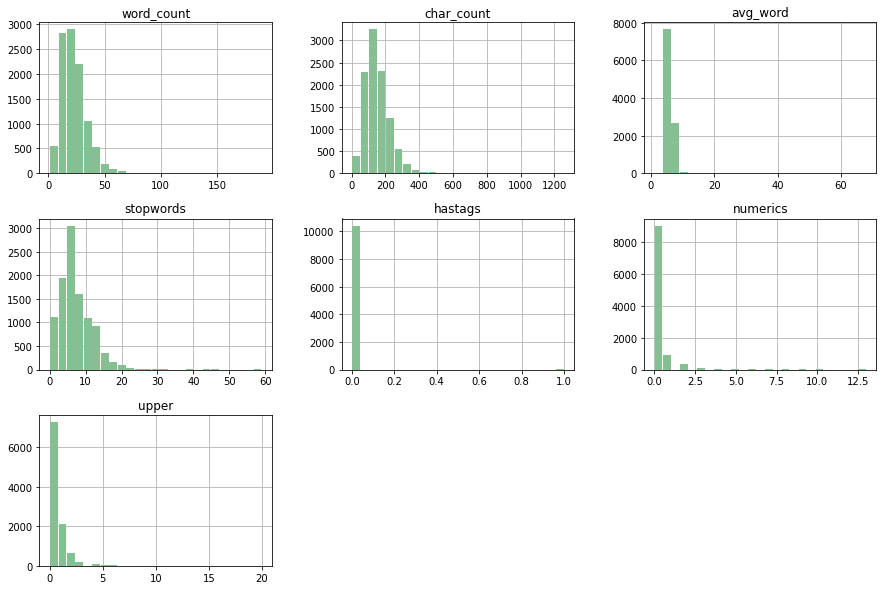

In [ ]:
# Visualize the results

swc_fed.hist(figsize=(15,10), bins=25, color='#86bf91', zorder=2, rwidth=0.9)

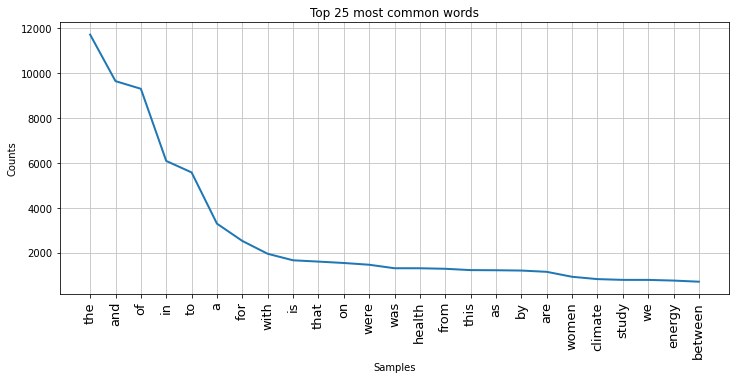

In [ ]:
# Find the most common words and visualize them

corpora_new = " ".join(swc_fed['sentence'])
top_words = Counter(corpora_new.split()).most_common()
all_words = []
for line in list(swc_fed['sentence']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)



> Adjust class weights



# Preprocessing 

---






> Clean Data



In [ ]:
# Clean the text from any unwanted symbols and convert letters into lower case

def clean_text(text):

    text = str(text)

    text = text.lower()

    text = re.sub(r"[^A-Za-z0-9]", " ", text)

    text = text.strip()

    return text

In [ ]:
# Apply the specific pre-process procedures

swc_doc['df']['sentence'] = swc_doc['df']['sentence'].apply(clean_text)

In [ ]:
# take a quick view once again

swc_doc['df']['sentence'].head()

0    green  consumption no solution for climate change
1    abstract  this article explores the quantitati...
2    it shows that green consumption patterns gener...
3    the reductions are  however  small and one exp...
4    the major conclusion is that adopting green pa...
Name: sentence, dtype: object



> Remove Stop-Words



In [ ]:
# Remove stop-words

stop = stopwords.words('english')
swc_doc['df']['sentence'] = swc_doc['df']['sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
# Declare properly our input variable (X) and the predicted output variable (y)

X = swc_doc['df']['sentence']
y = swc_doc['df']['label']

In [ ]:
X.head()

0            green consumption solution climate change
1    abstract article explores quantitative effect ...
2    shows green consumption patterns generally red...
3    reductions however small one experiment even s...
4    major conclusion adopting green patterns consu...
Name: sentence, dtype: object



> Split data to train-validation and test data



In [ ]:
y = np.array(y)

In [ ]:
test_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)

# splitting in train-val and test
X_train_val, X_test, y_train_val, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(X, y):
    
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

> Create the tokenizer

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer

In [ ]:
# Fitting the tokenizer on the train dataset only
tokenizer.fit_on_texts(X_train_val)

# Tokenize train data
sequences = tokenizer.texts_to_sequences(X_train_val)

# Tokenize test data
test_sequences = tokenizer.texts_to_sequences(X_test)



> Padding



In [ ]:
all_lengths = list(map(len, sequences))
max(all_lengths)

187

In [ ]:
# Check what is the maximum length for 99% of all sentences.
common_length_of_sentences = int(np.percentile(all_lengths, q=99))
print(f'common length of sentences (99%): {common_length_of_sentences}')

# Make all sequences 65 words long
max_len = 65
print(f'Max Length: {max_len}')

common length of sentences (99%): 43
Max Length: 65


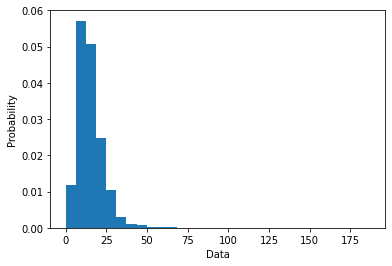

In [ ]:
# This also can be observed by the following plot

# Find the max words per sentence

words_per_sentence = list(len(i.split()) for i in X)
stats.describe(words_per_sentence)

# Histogram plot

plt.hist(words_per_sentence, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
# To proceed, we now have to make sure that all text sequences we feed into the model have the same length.
# We can do this with Keras pad sequences tool.
# It cuts of sequences that are too long and adds zeros to sequences that are too short.

X_padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

print('New train-validation data shape: {}'.format(X_padded))
print('New test data shape: {}'.format(X_test_padded))

New train-validation data shape: [[1793 1335   58 ...    0    0    0]
 [7512  580   44 ...    0    0    0]
 [ 544  652   38 ...    0    0    0]
 ...
 [  63  173 3382 ...    0    0    0]
 [   4  514 1106 ...    0    0    0]
 [ 310   20 1610 ...    0    0    0]]
New test data shape: [[ 190  313    4 ...    0    0    0]
 [ 296 2434  172 ...    0    0    0]
 [  52  198   31 ...    0    0    0]
 ...
 [  65  418  227 ...    0    0    0]
 [ 172  705 3064 ...    0    0    0]
 [ 914  289 1614 ...    0    0    0]]




> Total Number of words in vocabulary



In [ ]:
num_words = len(tokenizer.word_index) + 1
num_words

12048

In [ ]:
print(X_padded.shape)

print(X_test_padded.shape)

(8842, 65)
(1561, 65)


In [ ]:
print(y_train_val.shape)

print(y_test.shape)

(8842,)
(1561,)


# Import Modules

In [ ]:
# import all the necessary modules for the deployment of our models

from tensorflow.keras.models import Sequential
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.python.keras.layers import Embedding, LSTM, Input, Concatenate, Bidirectional, concatenate, GlobalMaxPool1D, Flatten
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
import keras
from tensorflow.python.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# To visualizse the architecture of each model
from keras.utils.vis_utils import plot_model

In [ ]:
# Usage of One Hot Encoder in our predicted variable

y_encoded = OneHotEncoder(sparse=False)
y_encoded.fit(y_train_val.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

# FeedForward neural network

In [ ]:
# Hyperparameters

batch_size = 64
nb_classes = 3
nb_epoch = 30
dropout_rate = 0.3
maxlen = max_len
max_features = num_words
embedding_dims = 50

entries = []



> Network's Architecture



In [ ]:
def build_model_mlp(max_len: int,
                    max_feats: int,
                    emb_dimensions: int,
                    dropout_rate: float,
                    nb_classes: int = 3):

    mlp_model = Sequential()

    mlp_model.add(Embedding(max_features,embedding_dims,input_length=maxlen))

    mlp_model.add(Flatten())

    # add a dense layer (MLP)
    mlp_model.add(Dense(150, input_shape=(max_len,)))

    # use a relu activation on MLP's outputs
    mlp_model.add(Activation('relu'))

    # use a dropout layer with with 40% of inputs dropped
    mlp_model.add(Dropout(dropout_rate))

    # add a dense layer (MLP)
    mlp_model.add(Dense(50))

    # use a relu activation on MLP's outputs
    mlp_model.add(Activation('relu'))

    # use a dropout layer with with 20% of inputs droped
    mlp_model.add(Dropout(dropout_rate))

    # add a dense layer (MLP)
    mlp_model.add(Dense(10))

    # use a relu activation on MLP's outputs
    mlp_model.add(Activation('relu'))

    # add a dense layer (MLP) 
    mlp_model.add(Dense(nb_classes))

    # use a softmax activation on 2nd MLP's outputs
    mlp_model.add(Activation('softmax'))

    # we have defined the structure of the model

    opt = keras.optimizers.Adam(learning_rate= 0.00005)
    mlp_model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['categorical_accuracy'])

    return mlp_model

In [ ]:
mlp_model = build_model_mlp(maxlen, max_features,embedding_dims, dropout_rate, nb_classes) 

# print model layers' info
print(mlp_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 65, 50)            602400    
_________________________________________________________________
flatten (Flatten)            (None, 3250)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               487650    
_________________________________________________________________
activation (Activation)      (None, 150)               0         
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                7550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0

In [ ]:
# Better visualize the architecture of the model

plot_model(mlp_model, to_file='mlp_model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
a = np.arange(0,len(X_padded),1)

kfold = StratifiedKFold(5,True,1)

# use temp_score to save the model with the highest test accuracy
temp_score = 0
for train_int, val_int in kfold.split(X_padded, y_train_val):
    X_train = X_padded[train_int]
    X_val = X_padded[val_int]
    y_train = y_train_val[train_int]
    y_val = y_train_val[val_int]
    mlp_checkpoint= ModelCheckpoint(filepath='mlp_model.h5',mode='min',monitor='val_loss',verbose=2,save_best_only=True)
    

    # We use the fit_transform on the training data
    y_train_enc = y_encoded.transform(y_train.reshape(-1,1))
    y_val_enc = y_encoded.transform(y_val.reshape(-1,1))
    y_test_enc = y_encoded.transform(y_test.reshape(-1,1))

    # We insert the class weights according to our training data
    y_integers = np.argmax(y_train_enc, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))

    
    mlp_model = build_model_mlp(maxlen, max_features,embedding_dims, dropout_rate, nb_classes) 

   # Fitting the model
    history1 = mlp_model.fit(
        x=X_train,           # features (as dense inputs)
        y=y_train_enc,           # labels
        callbacks=[mlp_checkpoint],
        batch_size=batch_size,   # define batch size
        epochs=nb_epoch,         # number of epochs
        verbose=1,               # the most extended verbosity level
        validation_data=(       
        X_val,               # the validation split that we did before
        y_val_enc),
        class_weight = d_class_weights
    )
    
    final_mlp_model = keras.models.load_model('mlp_model.h5')
    
    score = final_mlp_model.evaluate(
        X_test_padded,    # features
        y_test_enc,              # labels
        batch_size=batch_size,   # batch size
        verbose=2                # the most extended verbose
    )
    entries.append(("MLP",score[1]))
    
    # Save the model with the highest test accuracy 
    if temp_score < score[1]:
        temp_score = score[1]
        mlp_model.save('final_mlp_model.h5')
        print('--- saving model final_mlp_model.h5 ---')

    print('Next Iteration\n')
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/30
107/111 [===========================>..] - ETA: 0s - loss: 1.0955 - categorical_accuracy: 0.5654 ETA: 0s - loss: 1.0897 - categorical_accura
Epoch 00001: val_loss improved from inf to 1.06537, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 1.0963 - categorical_accuracy: 0.5654 - val_loss: 1.0654 - val_categorical_accuracy: 0.5551
Epoch 2/30
110/111 [============================>.] - ETA: 0s - loss: 1.0895 - categorical_accuracy: 0.6045
Epoch 00002: val_loss improved from 1.06537 to 1.03445, saving model to mlp_model.h5
111/111 [==============================] - 2s 14ms/step - loss: 1.0893 - categorical_accuracy: 0.6048 - val_loss: 1.0345 - val_categorical_accuracy: 0.5969
Epoch 3/30
108/111 [============================>.] - ETA: 0s - loss: 1.0885 - categorical_accuracy: 0.6021
Epoch 00003: val_loss did not improve from 1.03445
111/111 [==============================] - 1s 13ms/step - loss: 1.0831 - categorical_accuracy: 0.6009 -

Epoch 25/30
111/111 [==============================] - ETA: 0s - loss: 0.1756 - categorical_accuracy: 0.9577
Epoch 00025: val_loss did not improve from 0.66173
111/111 [==============================] - 2s 14ms/step - loss: 0.1756 - categorical_accuracy: 0.9577 - val_loss: 0.7393 - val_categorical_accuracy: 0.7089
Epoch 26/30
109/111 [============================>.] - ETA: 0s - loss: 0.1478 - categorical_accuracy: 0.9670
Epoch 00026: val_loss did not improve from 0.66173
111/111 [==============================] - 2s 14ms/step - loss: 0.1471 - categorical_accuracy: 0.9673 - val_loss: 0.7247 - val_categorical_accuracy: 0.7343
Epoch 27/30
109/111 [============================>.] - ETA: 0s - loss: 0.1336 - categorical_accuracy: 0.9683
Epoch 00027: val_loss did not improve from 0.66173
111/111 [==============================] - 2s 14ms/step - loss: 0.1334 - categorical_accuracy: 0.9685 - val_loss: 0.7544 - val_categorical_accuracy: 0.7185
Epoch 28/30
111/111 [==============================]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


108/111 [============================>.] - ETA: 0s - loss: 1.1007 - categorical_accuracy: 0.4429
Epoch 00001: val_loss improved from inf to 1.07356, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 1.0961 - categorical_accuracy: 0.4446 - val_loss: 1.0736 - val_categorical_accuracy: 0.6184
Epoch 2/30
110/111 [============================>.] - ETA: 0s - loss: 1.0893 - categorical_accuracy: 0.5628
Epoch 00002: val_loss improved from 1.07356 to 1.05955, saving model to mlp_model.h5
111/111 [==============================] - 2s 14ms/step - loss: 1.0904 - categorical_accuracy: 0.5626 - val_loss: 1.0595 - val_categorical_accuracy: 0.5992
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 1.0862 - categorical_accuracy: 0.5251 ETA: 1s
Epoch 00003: val_loss did not improve from 1.05955
111/111 [==============================] - 2s 14ms/step - loss: 1.0850 - categorical_accuracy: 0.5238 - val_loss: 1.0895 - val_categorical_accuracy: 0

Epoch 25/30
109/111 [============================>.] - ETA: 0s - loss: 0.1823 - categorical_accuracy: 0.9429
Epoch 00025: val_loss did not improve from 0.60806
111/111 [==============================] - 2s 14ms/step - loss: 0.1816 - categorical_accuracy: 0.9436 - val_loss: 0.6250 - val_categorical_accuracy: 0.7569
Epoch 26/30
110/111 [============================>.] - ETA: 0s - loss: 0.1538 - categorical_accuracy: 0.9511
Epoch 00026: val_loss did not improve from 0.60806
111/111 [==============================] - 2s 14ms/step - loss: 0.1535 - categorical_accuracy: 0.9514 - val_loss: 0.6266 - val_categorical_accuracy: 0.7598
Epoch 27/30
109/111 [============================>.] - ETA: 0s - loss: 0.1308 - categorical_accuracy: 0.9600
Epoch 00027: val_loss did not improve from 0.60806
111/111 [==============================] - 2s 14ms/step - loss: 0.1310 - categorical_accuracy: 0.9600 - val_loss: 0.6203 - val_categorical_accuracy: 0.7677
Epoch 28/30
108/111 [============================>.]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


111/111 [==============================] - ETA: 0s - loss: 1.0981 - categorical_accuracy: 0.2327
Epoch 00001: val_loss improved from inf to 1.09933, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 1.0981 - categorical_accuracy: 0.2327 - val_loss: 1.0993 - val_categorical_accuracy: 0.1227
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0938 - categorical_accuracy: 0.1885
Epoch 00002: val_loss did not improve from 1.09933
111/111 [==============================] - 2s 14ms/step - loss: 1.0957 - categorical_accuracy: 0.1877 - val_loss: 1.1000 - val_categorical_accuracy: 0.1120
Epoch 3/30
108/111 [============================>.] - ETA: 0s - loss: 1.0910 - categorical_accuracy: 0.2413
Epoch 00003: val_loss improved from 1.09933 to 1.09482, saving model to mlp_model.h5
111/111 [==============================] - 2s 14ms/step - loss: 1.0931 - categorical_accuracy: 0.2409 - val_loss: 1.0948 - val_categorical_accuracy: 0.1188
Ep

Epoch 25/30
108/111 [============================>.] - ETA: 0s - loss: 0.2234 - categorical_accuracy: 0.9275
Epoch 00025: val_loss improved from 0.68356 to 0.67960, saving model to mlp_model.h5
111/111 [==============================] - 2s 14ms/step - loss: 0.2230 - categorical_accuracy: 0.9276 - val_loss: 0.6796 - val_categorical_accuracy: 0.7483
Epoch 26/30
111/111 [==============================] - ETA: 0s - loss: 0.1995 - categorical_accuracy: 0.9422
Epoch 00026: val_loss did not improve from 0.67960
111/111 [==============================] - 2s 14ms/step - loss: 0.1995 - categorical_accuracy: 0.9422 - val_loss: 0.6937 - val_categorical_accuracy: 0.7466
Epoch 27/30
108/111 [============================>.] - ETA: 0s - loss: 0.1761 - categorical_accuracy: 0.9459
Epoch 00027: val_loss did not improve from 0.67960
111/111 [==============================] - 2s 14ms/step - loss: 0.1753 - categorical_accuracy: 0.9467 - val_loss: 0.6933 - val_categorical_accuracy: 0.7506
Epoch 28/30
110/11

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


108/111 [============================>.] - ETA: 0s - loss: 1.0956 - categorical_accuracy: 0.3734
Epoch 00001: val_loss improved from inf to 1.07936, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 1.0966 - categorical_accuracy: 0.3781 - val_loss: 1.0794 - val_categorical_accuracy: 0.6278
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0909 - categorical_accuracy: 0.5156
Epoch 00002: val_loss improved from 1.07936 to 1.06038, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 1.0923 - categorical_accuracy: 0.5164 - val_loss: 1.0604 - val_categorical_accuracy: 0.6273
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 1.0861 - categorical_accuracy: 0.4936
Epoch 00003: val_loss improved from 1.06038 to 1.04584, saving model to mlp_model.h5
111/111 [==============================] - 2s 14ms/step - loss: 1.0856 - categorical_accuracy: 0.4946 - val_loss: 1.0458 - v

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


111/111 [==============================] - ETA: 0s - loss: 1.0981 - categorical_accuracy: 0.2878
Epoch 00001: val_loss improved from inf to 1.08759, saving model to mlp_model.h5
111/111 [==============================] - 2s 16ms/step - loss: 1.0981 - categorical_accuracy: 0.2878 - val_loss: 1.0876 - val_categorical_accuracy: 0.5175
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0942 - categorical_accuracy: 0.5411
Epoch 00002: val_loss improved from 1.08759 to 1.05886, saving model to mlp_model.h5
111/111 [==============================] - 2s 14ms/step - loss: 1.0946 - categorical_accuracy: 0.5416 - val_loss: 1.0589 - val_categorical_accuracy: 0.6900
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 1.0903 - categorical_accuracy: 0.6044
Epoch 00003: val_loss improved from 1.05886 to 1.05251, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 1.0900 - categorical_accuracy: 0.6043 - val_loss: 1.0525 - v

Epoch 25/30
110/111 [============================>.] - ETA: 0s - loss: 0.2307 - categorical_accuracy: 0.9152 ETA: 0s - loss: 0.2261 - cate
Epoch 00025: val_loss did not improve from 0.66103
111/111 [==============================] - 2s 15ms/step - loss: 0.2305 - categorical_accuracy: 0.9153 - val_loss: 0.6691 - val_categorical_accuracy: 0.7132
Epoch 26/30
109/111 [============================>.] - ETA: 0s - loss: 0.2036 - categorical_accuracy: 0.9223
Epoch 00026: val_loss improved from 0.66103 to 0.63289, saving model to mlp_model.h5
111/111 [==============================] - 2s 15ms/step - loss: 0.2036 - categorical_accuracy: 0.9227 - val_loss: 0.6329 - val_categorical_accuracy: 0.7398
Epoch 27/30
108/111 [============================>.] - ETA: 0s - loss: 0.1760 - categorical_accuracy: 0.9337
Epoch 00027: val_loss did not improve from 0.63289
111/111 [==============================] - 2s 15ms/step - loss: 0.1753 - categorical_accuracy: 0.9337 - val_loss: 0.6618 - val_categorical_accur

In [ ]:
# Generating the corresponding plots for training / val loss and training / val accuracy

history=history1
def plot_keras_history(history):

    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])
 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

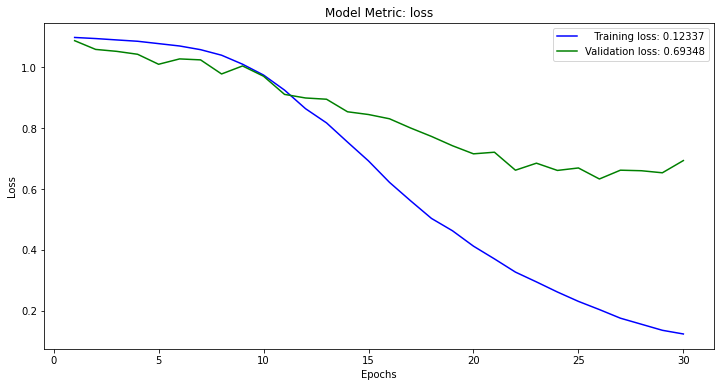

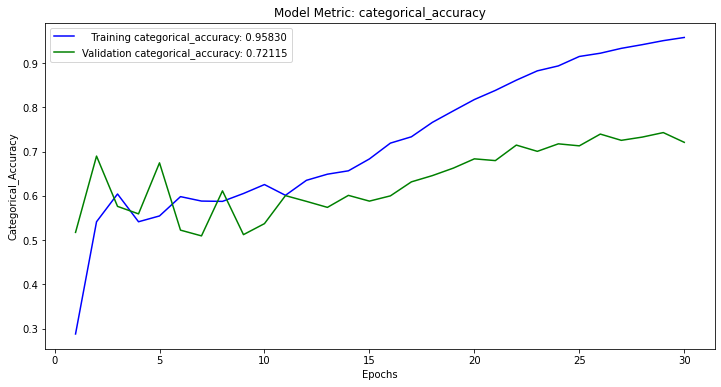

In [ ]:
plot_keras_history(history)

In [ ]:
print('\nTest categorical_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test categorical_crossentropy: 0.6401591300964355

Test accuracy: 75.657 %


# CNN

---

In [ ]:
# Hyperparameters
nb_classes = 3
nb_epoch = 30
dropout_rate = 0.4
maxlen = max_len
max_features = num_words
embedding_dims = 50
nof_filters = 64
kernel_size = 3

hidden_dims = 128

batch_size = 64



> Network's Architecture



In [ ]:
def build_model_cnn(max_len: int,
                    max_feats: int,
                    emb_dimensions: int,
                    dropout_rate: float,
                    nb_classes: int = 3):

    cnn_model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    cnn_model.add(Embedding(max_features,embedding_dims,input_length=maxlen))


    cnn_model.add(Dropout(dropout_rate))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:

    cnn_model.add(Conv1D(nof_filters, kernel_size,activation='relu', padding='same'))

    cnn_model.add(MaxPooling1D())

    cnn_model.add(Flatten())
    
    cnn_model.add(Dropout(dropout_rate))

    cnn_model.add(Dense(150, activation='relu'))
    
    cnn_model.add(Dense(50, activation='relu'))
    
    cnn_model.add(Dense(10, activation='relu'))

    cnn_model.add(Dense(nb_classes, activation='softmax'))


    opt = keras.optimizers.Adam(learning_rate= 0.00005)
    cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

    return cnn_model

In [ ]:
cnn_model = build_model_cnn(maxlen, max_features,embedding_dims, dropout_rate, nb_classes) 

# print model layers' info
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 65, 50)            602400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 65, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 65, 64)            9664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)              

In [ ]:
# Better visualize the architecture of the model

plot_model(cnn_model, to_file='cnn_model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
kfold = StratifiedKFold(5,True,1)
temp_score = 0
for train_int, val_int in kfold.split(X_padded, y_train_val):
    X_train = X_padded[train_int]
    X_val = X_padded[val_int]
    y_train = y_train_val[train_int]
    y_val = y_train_val[val_int]
    
    cnn_checkpoint= ModelCheckpoint(filepath='cnn_model.h5',mode='min',monitor='val_loss',verbose=2,save_best_only=True)
    
    # We use the fit_transform on the training data
    y_train_enc = y_encoded.transform(y_train.reshape(-1,1))
    y_val_enc = y_encoded.transform(y_val.reshape(-1,1))
    y_test_enc = y_encoded.transform(y_test.reshape(-1,1))

    # We insert the class weights according to our training data
    y_integers = np.argmax(y_train_enc, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))

    
    cnn_model = build_model_cnn(maxlen, max_features,embedding_dims, dropout_rate, nb_classes) 

    # Fitting the model
    
    # We train (fit our data to) our model
    history_2 = cnn_model.fit(
        x=X_train,           # features (as dense inputs)
        y=y_train_enc,           # labels
        batch_size=batch_size,   # define batch size
        epochs=nb_epoch,         # number of epochs
        verbose=1,
        validation_data=(       
        X_val,               # the validation split that we did before
        y_val_enc),
        callbacks=[cnn_checkpoint],
        class_weight = d_class_weights              # the most extended verbosity level
    )
    final_cnn_model = keras.models.load_model('cnn_model.h5')
    
    score = final_cnn_model.evaluate(
        X_test_padded,    # features
        y_test_enc,     # labels
        batch_size=batch_size,   # batch size
        verbose=2                # the most extended verbose
    )
    entries.append(("CNN",score[1]))

    if temp_score < score[1]:
        temp_score = score[1]
        cnn_model.save('final_cnn_model.h5')
        print('--- saving model final_cnn_model.h5 ---')
    

    print('Next Iteration\n')
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/30
109/111 [============================>.] - ETA: 0s - loss: 1.0997 - categorical_accuracy: 0.2388
Epoch 00001: val_loss improved from inf to 1.09777, saving model to cnn_model.h5
111/111 [==============================] - 2s 21ms/step - loss: 1.0990 - categorical_accuracy: 0.2382 - val_loss: 1.0978 - val_categorical_accuracy: 0.2549
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0965 - categorical_accuracy: 0.1940
Epoch 00002: val_loss did not improve from 1.09777
111/111 [==============================] - 2s 20ms/step - loss: 1.0977 - categorical_accuracy: 0.1948 - val_loss: 1.0999 - val_categorical_accuracy: 0.2951
Epoch 3/30
109/111 [============================>.] - ETA: 0s - loss: 1.0974 - categorical_accuracy: 0.1709
Epoch 00003: val_loss did not improve from 1.09777
111/111 [==============================] - 3s 24ms/step - loss: 1.0950 - categorical_accuracy: 0.1698 - val_loss: 1.1068 - val_categorical_accuracy: 0.2764
Epoch 4/30
109/111 [=====

Epoch 26/30
109/111 [============================>.] - ETA: 0s - loss: 0.7288 - categorical_accuracy: 0.7709
Epoch 00026: val_loss did not improve from 0.96862
111/111 [==============================] - 2s 21ms/step - loss: 0.7276 - categorical_accuracy: 0.7711 - val_loss: 0.9863 - val_categorical_accuracy: 0.6473
Epoch 27/30
110/111 [============================>.] - ETA: 0s - loss: 0.6843 - categorical_accuracy: 0.7906
Epoch 00027: val_loss improved from 0.96862 to 0.93124, saving model to cnn_model.h5
111/111 [==============================] - 2s 22ms/step - loss: 0.6849 - categorical_accuracy: 0.7902 - val_loss: 0.9312 - val_categorical_accuracy: 0.6665
Epoch 28/30
111/111 [==============================] - ETA: 0s - loss: 0.6519 - categorical_accuracy: 0.7977
Epoch 00028: val_loss improved from 0.93124 to 0.92722, saving model to cnn_model.h5
111/111 [==============================] - 2s 21ms/step - loss: 0.6519 - categorical_accuracy: 0.7977 - val_loss: 0.9272 - val_categorical_a

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


109/111 [============================>.] - ETA: 0s - loss: 1.0960 - categorical_accuracy: 0.5235
Epoch 00001: val_loss improved from inf to 1.08362, saving model to cnn_model.h5
111/111 [==============================] - 2s 21ms/step - loss: 1.0981 - categorical_accuracy: 0.5237 - val_loss: 1.0836 - val_categorical_accuracy: 0.7207
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0961 - categorical_accuracy: 0.6243
Epoch 00002: val_loss improved from 1.08362 to 1.07294, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 1.0963 - categorical_accuracy: 0.6251 - val_loss: 1.0729 - val_categorical_accuracy: 0.7394
Epoch 3/30
109/111 [============================>.] - ETA: 0s - loss: 1.0933 - categorical_accuracy: 0.6766 ETA: 0s - loss: 1.1
Epoch 00003: val_loss improved from 1.07294 to 1.05752, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 1.0941 - categorical_accuracy: 0.6761 - 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


109/111 [============================>.] - ETA: 0s - loss: 1.0967 - categorical_accuracy: 0.2202
Epoch 00001: val_loss improved from inf to 1.09714, saving model to cnn_model.h5
111/111 [==============================] - 2s 21ms/step - loss: 1.0982 - categorical_accuracy: 0.2234 - val_loss: 1.0971 - val_categorical_accuracy: 0.5566
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0977 - categorical_accuracy: 0.2618
Epoch 00002: val_loss improved from 1.09714 to 1.09056, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 1.0953 - categorical_accuracy: 0.2653 - val_loss: 1.0906 - val_categorical_accuracy: 0.6278
Epoch 3/30
109/111 [============================>.] - ETA: 0s - loss: 1.0904 - categorical_accuracy: 0.4655
Epoch 00003: val_loss improved from 1.09056 to 1.08821, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 1.0901 - categorical_accuracy: 0.4669 - val_loss: 1.0882 - v

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


111/111 [==============================] - ETA: 0s - loss: 1.0972 - categorical_accuracy: 0.2070
Epoch 00001: val_loss improved from inf to 1.10061, saving model to cnn_model.h5
111/111 [==============================] - 2s 21ms/step - loss: 1.0972 - categorical_accuracy: 0.2070 - val_loss: 1.1006 - val_categorical_accuracy: 0.2212
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0950 - categorical_accuracy: 0.2377
Epoch 00002: val_loss did not improve from 1.10061
111/111 [==============================] - 2s 20ms/step - loss: 1.0944 - categorical_accuracy: 0.2378 - val_loss: 1.1020 - val_categorical_accuracy: 0.1278
Epoch 3/30
109/111 [============================>.] - ETA: 0s - loss: 1.0907 - categorical_accuracy: 0.2056
Epoch 00003: val_loss did not improve from 1.10061
111/111 [==============================] - 2s 20ms/step - loss: 1.0886 - categorical_accuracy: 0.2077 - val_loss: 1.1015 - val_categorical_accuracy: 0.1284
Epoch 4/30
109/111 [================

Epoch 26/30
109/111 [============================>.] - ETA: 0s - loss: 0.5643 - categorical_accuracy: 0.7190
Epoch 00026: val_loss did not improve from 0.93040
111/111 [==============================] - 2s 20ms/step - loss: 0.5662 - categorical_accuracy: 0.7164 - val_loss: 0.9699 - val_categorical_accuracy: 0.5198
Epoch 27/30
109/111 [============================>.] - ETA: 0s - loss: 0.5448 - categorical_accuracy: 0.7324
Epoch 00027: val_loss improved from 0.93040 to 0.92414, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 0.5443 - categorical_accuracy: 0.7331 - val_loss: 0.9241 - val_categorical_accuracy: 0.5877
Epoch 28/30
109/111 [============================>.] - ETA: 0s - loss: 0.5269 - categorical_accuracy: 0.7408
Epoch 00028: val_loss did not improve from 0.92414
111/111 [==============================] - 2s 20ms/step - loss: 0.5263 - categorical_accuracy: 0.7400 - val_loss: 0.9553 - val_categorical_accuracy: 0.5560
Epoch 29/30
109/11

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


109/111 [============================>.] - ETA: 0s - loss: 1.0952 - categorical_accuracy: 0.1339
Epoch 00001: val_loss improved from inf to 1.09721, saving model to cnn_model.h5
111/111 [==============================] - 2s 21ms/step - loss: 1.0987 - categorical_accuracy: 0.1354 - val_loss: 1.0972 - val_categorical_accuracy: 0.2777
Epoch 2/30
109/111 [============================>.] - ETA: 0s - loss: 1.0976 - categorical_accuracy: 0.2345
Epoch 00002: val_loss improved from 1.09721 to 1.09377, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 1.0974 - categorical_accuracy: 0.2362 - val_loss: 1.0938 - val_categorical_accuracy: 0.4576
Epoch 3/30
109/111 [============================>.] - ETA: 0s - loss: 1.0950 - categorical_accuracy: 0.4323
Epoch 00003: val_loss improved from 1.09377 to 1.08957, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 1.0953 - categorical_accuracy: 0.4312 - val_loss: 1.0896 - v

Epoch 25/30
110/111 [============================>.] - ETA: 0s - loss: 0.4909 - categorical_accuracy: 0.8112
Epoch 00025: val_loss did not improve from 0.71539
111/111 [==============================] - 2s 20ms/step - loss: 0.4901 - categorical_accuracy: 0.8113 - val_loss: 0.7230 - val_categorical_accuracy: 0.6980
Epoch 26/30
110/111 [============================>.] - ETA: 0s - loss: 0.4511 - categorical_accuracy: 0.8247
Epoch 00026: val_loss improved from 0.71539 to 0.70487, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 0.4526 - categorical_accuracy: 0.8244 - val_loss: 0.7049 - val_categorical_accuracy: 0.7064
Epoch 27/30
109/111 [============================>.] - ETA: 0s - loss: 0.4192 - categorical_accuracy: 0.8337 ETA: 1s - los
Epoch 00027: val_loss improved from 0.70487 to 0.68041, saving model to cnn_model.h5
111/111 [==============================] - 2s 20ms/step - loss: 0.4199 - categorical_accuracy: 0.8346 - val_loss: 0.6804 - val

In [ ]:
# Generating the corresponding plots for training / val loss and training / val accuracy

history=history_2
def plot_keras_history(history):

    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])
 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

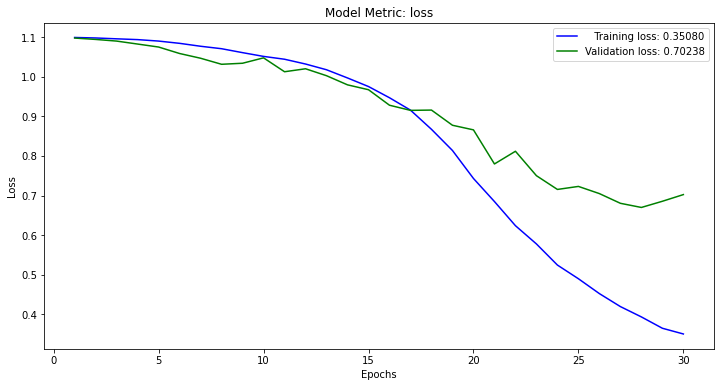

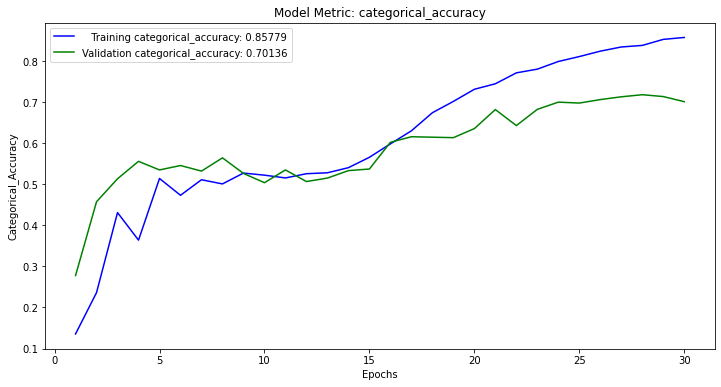

In [ ]:
plot_keras_history(history)

In [ ]:
print('\nTest categorical_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test categorical_crossentropy: 0.6961421966552734

Test accuracy: 71.300 %


# RNN
---

In [ ]:
# Hyperparameters
nb_classes = 3
nb_epoch = 10
dropout_rate = 0.5
maxlen = max_len
max_features = num_words
embedding_dims = 50
batch_size = 32



> Model's Architecture



In [ ]:
def build_model_rnn(max_len: int,
                    max_feats: int,
                    emb_dimensions: int,
                    dropout_rate: float,
                    nb_classes: int = 3):

    rnn_model = Sequential()

    Input(shape=(max_len,), dtype='int32')


    rnn_model.add(Embedding(max_feats, emb_dimensions, input_length=max_len))

    rnn_model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=dropout_rate)))

    rnn_model.add(Flatten())
    
    rnn_model.add(Dropout(dropout_rate))

    rnn_model.add(Dense(256, activation='relu'))
    
    rnn_model.add(Activation('relu'))
    
    rnn_model.add(Dropout(dropout_rate))

    # add a dense layer (MLP) 
    rnn_model.add(Dense(nb_classes))

    # use a softmax activation on 2nd MLP's outputs
    rnn_model.add(Activation('softmax'))



    opt = keras.optimizers.Adam(learning_rate=0.00005)
    rnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

    return rnn_model

In [ ]:
rnn_model = build_model_rnn(maxlen, max_features,embedding_dims, dropout_rate, nb_classes) 

# print model layers' info

print(rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 50)            602400    
_________________________________________________________________
bidirectional (Bidirectional (None, 65, 128)           58880     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8320)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8320)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2130176   
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [ ]:
# Better visualize the architecture of the model

plot_model(rnn_model, to_file='rnn_model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
kfold = StratifiedKFold(5,True,1)

    
temp_score = 0
for train_int, val_int in kfold.split(X_padded, y_train_val):
    X_train = X_padded[train_int]
    X_val = X_padded[val_int]
    y_train = y_train_val[train_int]
    y_val = y_train_val[val_int]
    
    # Checkpoint
    rnn_checkpoint= ModelCheckpoint(filepath='rnn_model.h5',mode='min',monitor='val_loss',verbose=2,save_best_only=True)

    # We use the fit_transform on the training data
    y_train_enc = y_encoded.transform(y_train.reshape(-1,1))
    y_val_enc = y_encoded.transform(y_val.reshape(-1,1))
    y_test_enc = y_encoded.transform(y_test.reshape(-1,1))

    # We insert the class weights according to our training data
    y_integers = np.argmax(y_train_enc, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))

    
    rnn_model = build_model_rnn(maxlen, max_features,embedding_dims, dropout_rate, nb_classes) 

    # Fitting the model
    
    history_3 = rnn_model.fit(
    x=X_train,           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=1,
    validation_data=(       
    X_val,               # the validation split that we did before
    y_val_enc), 
    class_weight = d_class_weights,              # the most extended verbosity level
    callbacks=[rnn_checkpoint]
    )


    final_rnn_model = keras.models.load_model('rnn_model.h5')
    
    score = final_rnn_model.evaluate(
    X_test_padded,    # features
    y_test_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
    )
    entries.append(("RNN",score[1]))
    
    if temp_score < score[1]:
        temp_score = score[1]
        rnn_model.save('final_rnn_model.h5')
        print('--- saving model final_rnn_model.h5 ---')
    
    print('Next Iteration\n')
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/10
222/222 [==============================] - ETA: 0s - loss: 1.0921 - categorical_accuracy: 0.5425
Epoch 00001: val_loss improved from inf to 1.05351, saving model to rnn_model.h5
222/222 [==============================] - 24s 109ms/step - loss: 1.0921 - categorical_accuracy: 0.5425 - val_loss: 1.0535 - val_categorical_accuracy: 0.5393
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 1.0692 - categorical_accuracy: 0.5086
Epoch 00002: val_loss improved from 1.05351 to 1.03541, saving model to rnn_model.h5
222/222 [==============================] - 23s 105ms/step - loss: 1.0692 - categorical_accuracy: 0.5086 - val_loss: 1.0354 - val_categorical_accuracy: 0.5291
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 1.0404 - categorical_accuracy: 0.5274
Epoch 00003: val_loss did not improve from 1.03541
222/222 [==============================] - 24s 108ms/step - loss: 1.0404 - categorical_accuracy: 0.5274 - val_loss: 1.0468 - val_categorical_ac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/10
222/222 [==============================] - ETA: 0s - loss: 1.0928 - categorical_accuracy: 0.5537
Epoch 00001: val_loss improved from inf to 1.04014, saving model to rnn_model.h5
222/222 [==============================] - 25s 113ms/step - loss: 1.0928 - categorical_accuracy: 0.5537 - val_loss: 1.0401 - val_categorical_accuracy: 0.5184
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 1.0761 - categorical_accuracy: 0.51 - ETA: 0s - loss: 1.0763 - categorical_accuracy: 0.5152
Epoch 00002: val_loss did not improve from 1.04014
222/222 [==============================] - 25s 111ms/step - loss: 1.0763 - categorical_accuracy: 0.5152 - val_loss: 1.0474 - val_categorical_accuracy: 0.4845
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 1.0512 - categorical_accuracy: 0.4968
Epoch 00003: val_loss improved from 1.04014 to 1.03203, saving model to rnn_model.h5
222/222 [==============================] - 25s 111ms/step - loss: 1.0512 - categorical_ac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/10
222/222 [==============================] - ETA: 0s - loss: 1.0919 - categorical_accuracy: 0.4876
Epoch 00001: val_loss improved from inf to 1.03488, saving model to rnn_model.h5
222/222 [==============================] - 28s 124ms/step - loss: 1.0919 - categorical_accuracy: 0.4876 - val_loss: 1.0349 - val_categorical_accuracy: 0.5673
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 1.0736 - categorical_accuracy: 0.4941
Epoch 00002: val_loss improved from 1.03488 to 1.00391, saving model to rnn_model.h5
222/222 [==============================] - 28s 125ms/step - loss: 1.0736 - categorical_accuracy: 0.4941 - val_loss: 1.0039 - val_categorical_accuracy: 0.5436
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 1.0539 - categorical_accuracy: 0.5110
Epoch 00003: val_loss did not improve from 1.00391
222/222 [==============================] - 26s 116ms/step - loss: 1.0539 - categorical_accuracy: 0.5110 - val_loss: 1.0553 - val_categorical_ac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/10
222/222 [==============================] - ETA: 0s - loss: 1.0918 - categorical_accuracy: 0.5841
Epoch 00001: val_loss improved from inf to 1.06434, saving model to rnn_model.h5
222/222 [==============================] - 22s 100ms/step - loss: 1.0918 - categorical_accuracy: 0.5841 - val_loss: 1.0643 - val_categorical_accuracy: 0.5096
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 1.0748 - categorical_accuracy: 0.5006
Epoch 00002: val_loss improved from 1.06434 to 0.97904, saving model to rnn_model.h5
222/222 [==============================] - 21s 94ms/step - loss: 1.0748 - categorical_accuracy: 0.5006 - val_loss: 0.9790 - val_categorical_accuracy: 0.5764
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 1.0559 - categorical_accuracy: 0.5034
Epoch 00003: val_loss did not improve from 0.97904
222/222 [==============================] - 21s 94ms/step - loss: 1.0559 - categorical_accuracy: 0.5034 - val_loss: 1.0513 - val_categorical_accu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/10
222/222 [==============================] - ETA: 0s - loss: 1.0929 - categorical_accuracy: 0.5329
Epoch 00001: val_loss improved from inf to 1.07119, saving model to rnn_model.h5
222/222 [==============================] - 22s 100ms/step - loss: 1.0929 - categorical_accuracy: 0.5329 - val_loss: 1.0712 - val_categorical_accuracy: 0.4932
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 1.0773 - categorical_accuracy: 0.4823
Epoch 00002: val_loss improved from 1.07119 to 1.04406, saving model to rnn_model.h5
222/222 [==============================] - 25s 115ms/step - loss: 1.0773 - categorical_accuracy: 0.4823 - val_loss: 1.0441 - val_categorical_accuracy: 0.4904
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 1.0547 - categorical_accuracy: 0.4963
Epoch 00003: val_loss improved from 1.04406 to 1.00976, saving model to rnn_model.h5
222/222 [==============================] - 24s 108ms/step - loss: 1.0547 - categorical_accuracy: 0.4963 - val

In [ ]:
# Generating the corresponding plots for training / val loss and training / val accuracy

history=history_3
def plot_keras_history(history):

    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])
 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

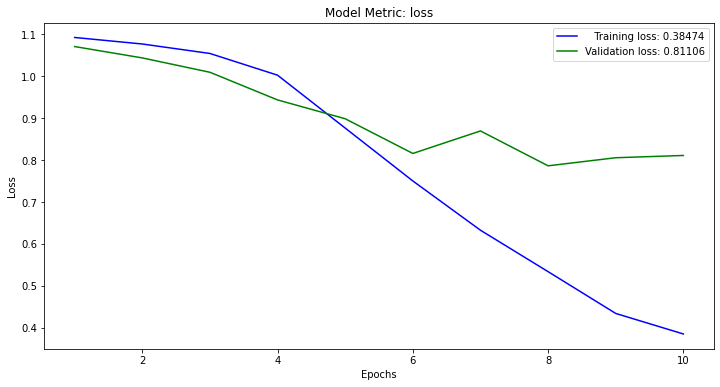

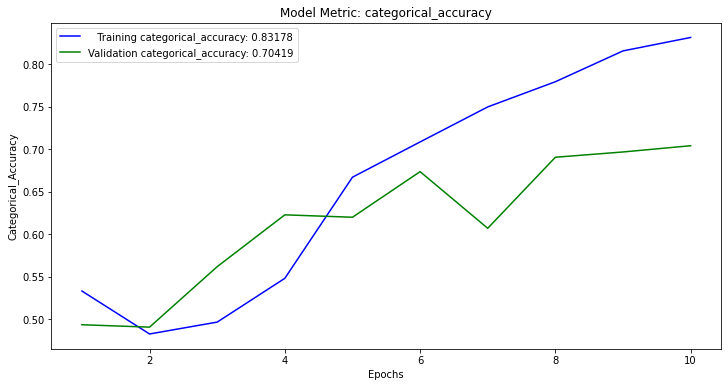

In [ ]:
plot_keras_history(history)

In [ ]:
print('\nTest categorical_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test categorical_crossentropy: 0.7796081304550171

Test accuracy: 69.955 %


# Results
---

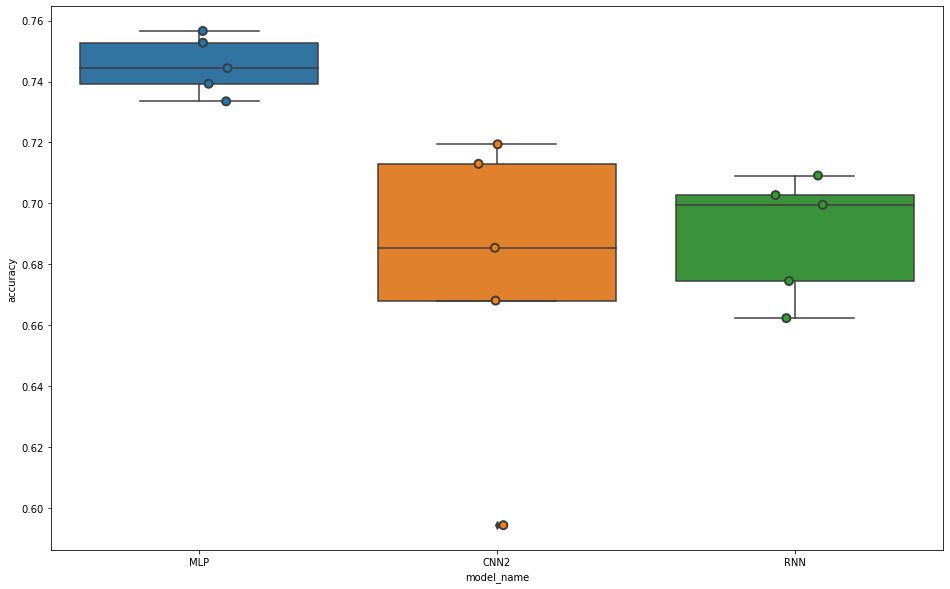

In [ ]:
# Boxplot representation of the final results

import seaborn as sns
import pandas as pd

cv_df = pd.DataFrame(entries, columns=['model_name','accuracy'])

plt.figure(figsize=(16, 10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



> Confusion Matrices for each Model



In [ ]:
# Use to yield probability distribution over the categories

final_mlp_model = keras.models.load_model('final_mlp_model.h5')
y_test_pred_probs_mlp = final_mlp_model.predict(X_test_padded)

final_cnn_model = keras.models.load_model('final_cnn_model.h5')
y_test_pred_probs_cnn = final_cnn_model.predict(X_test_padded)

final_rnn_model = keras.models.load_model('final_rnn_model.h5')
y_test_pred_probs_rnn = final_rnn_model.predict(X_test_padded)

# Store modelσ to json format
open('mlp_model.json','w').write(final_mlp_model.to_json())

open('cnn_model.json','w').write(final_cnn_model.to_json())

open('rnn_model.json','w').write(final_rnn_model.to_json())

y_test_preds_mlp = np.argmax(final_mlp_model.predict(X_test_padded), axis=-1)
y_test_preds_cnn = np.argmax(final_cnn_model.predict(X_test_padded), axis=-1)
y_test_preds_rnn = np.argmax(final_rnn_model.predict(X_test_padded), axis=-1)

In [ ]:
# prediction function 

def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

In [ ]:
# One hot predictions for the target variable

y_test_pred_mlp = get_one_hot_predictions(y_test_pred_probs_mlp)
y_test_pred_types_mlp = y_encoded.inverse_transform(y_test_pred_mlp).flatten()

y_test_pred_cnn = get_one_hot_predictions(y_test_pred_probs_cnn)
y_test_pred_types_cnn = y_encoded.inverse_transform(y_test_pred_cnn).flatten()

y_test_pred_rnn = get_one_hot_predictions(y_test_pred_probs_rnn)
y_test_pred_types_rnn = y_encoded.inverse_transform(y_test_pred_rnn).flatten()



> Confusion Matrices for each model



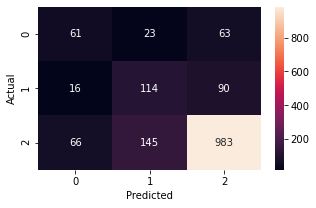

In [ ]:
# Confusion Matrix of the MLP model

import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_types_mlp)

pd.DataFrame(conf_mat,
             columns = y_encoded.categories_,
             index=y_encoded.categories_)
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

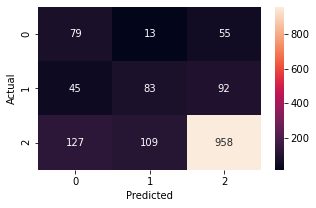

In [ ]:
# Confusion Matrix of the CNN model

conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_types_cnn)

pd.DataFrame(conf_mat,
             columns = y_encoded.categories_,
             index=y_encoded.categories_)
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

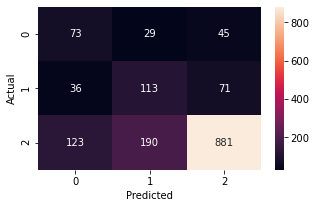

In [ ]:
# Confusion Matrix of the RNN model

conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_types_rnn)

pd.DataFrame(conf_mat,
             columns = y_encoded.categories_,
             index=y_encoded.categories_)
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



> Classification Report for each model



In [ ]:
# Classification Report of the MLP model

print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_types_mlp))

              precision    recall  f1-score   support

       CLAIM       0.43      0.41      0.42       147
    EVIDENCE       0.40      0.52      0.45       220
    NO LABEL       0.87      0.82      0.84      1194

    accuracy                           0.74      1561
   macro avg       0.57      0.59      0.57      1561
weighted avg       0.76      0.74      0.75      1561



In [ ]:
# Classification Report of the CNN model

print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_types_cnn))

              precision    recall  f1-score   support

       CLAIM       0.31      0.54      0.40       147
    EVIDENCE       0.40      0.38      0.39       220
    NO LABEL       0.87      0.80      0.83      1194

    accuracy                           0.72      1561
   macro avg       0.53      0.57      0.54      1561
weighted avg       0.75      0.72      0.73      1561



In [ ]:
# Classification Report of the RNN model

print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_types_rnn))

              precision    recall  f1-score   support

       CLAIM       0.31      0.50      0.39       147
    EVIDENCE       0.34      0.51      0.41       220
    NO LABEL       0.88      0.74      0.80      1194

    accuracy                           0.68      1561
   macro avg       0.51      0.58      0.53      1561
weighted avg       0.75      0.68      0.71      1561



# Blind test set predictions
---

In [ ]:
# Parsing the new corresponding file (blind test set)

class ArgumentParser:
    
    # Get the list of all the file paths
    @staticmethod
    def get_argument_files():
        return list(Path('argument_test_set/argument').glob('*.csv'))
    
    # Read each csv and append the lines in the list frames
    def setup_without_context(self):
        files = self.get_argument_files()
        frames = list()
        # For every file save the sentences and the file's name in a new column
        for file_path in tqdm(files):
            df = pd.read_csv(file_path, header=None, names=(['sentence']))
            df['file_origin_name'] = str(file_path).split('\\')[-1]
            frames.append(df)
        # Return the final dictionary with the dataframe, and the columns
        data = pd.concat(frames).reset_index(drop=True)
        return {'X': data.iloc[:,0].tolist(),
                'file_origin_name': data['file_origin_name'].tolist(),
                'df': data}

# Use the above functions to parse the files
if __name__ == "__main__":
    parser = ArgumentParser()
    
    blind_test_doc = parser.setup_without_context()
    print(blind_test_doc['df'][:10])


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 593.85it/s]


                                            sentence  \
0  Exploration and corrective measures of greenho...   
1                                          Abstract:   
2  Greenhouse gas emission is increasing alarming...   
3  While researchers are struggling to minimize t...   
4  This paper presents mathematical model of para...   
5  The Greenhouse gas emission from the existing ...   
6  The result shows that power plants of coal, di...   
7  Furthermore, several Greenhouse gas mitigating...   
8  An exploration into the household energy choic...   
9  Globally 1.3 billion people have no access to ...   

                             file_origin_name  
0  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  
1  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  
2  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  
3  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  
4  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  
5  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  
6  ABC_G1B1_10.1016 j.jclepro.2019.118645.csv  

In [ ]:
# Cleaning procedures

blind_test_doc['df']['sentence'] = blind_test_doc['df']['sentence'].apply(clean_text)
blind_test_doc['df']['sentence'].head()

0    exploration and corrective measures of greenho...
1                                             abstract
2    greenhouse gas emission is increasing alarming...
3    while researchers are struggling to minimize t...
4    this paper presents mathematical model of para...
Name: sentence, dtype: object

In [ ]:
# Remove stopwords

stop = stopwords.words('english')
blind_test_doc['df']['sentence'] = blind_test_doc['df']['sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

X = blind_test_doc['df']['sentence']
X.head()

0    exploration corrective measures greenhouse gas...
1                                             abstract
2    greenhouse gas emission increasing alarmingly ...
3    researchers struggling minimize emission using...
4    paper presents mathematical model parameters r...
Name: sentence, dtype: object

In [ ]:
# Tokenization and padding of X

sequences = tokenizer.texts_to_sequences(X)

X_blind_padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

print('New train-validation data shape: {}'.format(X_blind_padded))

New train-validation data shape: [[2837    1  228 ...    0    0    0]
 [  77    0    0 ...    0    0    0]
 [ 392  282  346 ...    0    0    0]
 ...
 [ 743   52  171 ...    0    0    0]
 [2176    1  165 ...    0    0    0]
 [3057 2690    1 ...    0    0    0]]


In [ ]:
# load the best model and make the predictions

final_mlp_model = keras.models.load_model('final_mlp_model.h5')
y_blind_pred = final_mlp_model.predict(X_blind_padded)

In [ ]:
y_blind_pred

array([[2.9520676e-02, 4.3737784e-01, 5.3310150e-01],
       [9.0765790e-04, 2.0791134e-03, 9.9701321e-01],
       [3.1713303e-02, 9.4754942e-02, 8.7353182e-01],
       ...,
       [3.4920441e-03, 2.0324896e-01, 7.9325902e-01],
       [6.9567180e-01, 2.0466892e-02, 2.8386128e-01],
       [4.5191150e-02, 4.4888340e-02, 9.0992051e-01]], dtype=float32)

In [ ]:
# One Hot Encoding at the target variable

y_encoded = OneHotEncoder(sparse=False)

y_encoded.fit(y_train_val.reshape(-1,1))

y_blind_pred = get_one_hot_predictions(y_blind_pred)
y_blind_pred = y_encoded.inverse_transform(y_blind_pred).flatten()

In [ ]:
y_blind_pred

array(['NO LABEL', 'NO LABEL', 'NO LABEL', ..., 'NO LABEL', 'CLAIM',
       'NO LABEL'], dtype=object)

In [ ]:
# Save the predictions in a new column

blind_test_doc['df']['label_predictions'] = y_blind_pred

In [ ]:
blind_test_doc['df'].head(20)

,sentence,file_origin_name,label_predictions
0,exploration corrective measures greenhouse gas...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,NO LABEL
1,abstract,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,NO LABEL
2,greenhouse gas emission increasing alarmingly ...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,NO LABEL
3,researchers struggling minimize emission using...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,NO LABEL
4,paper presents mathematical model parameters r...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,NO LABEL
5,greenhouse gas emission existing fossil fuel p...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,NO LABEL
6,result shows power plants coal diesel natural ...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,EVIDENCE
7,furthermore several greenhouse gas mitigating ...,ABC_G1B1_10.1016 j.jclepro.2019.118645.csv,EVIDENCE
8,exploration household energy choice expenditur...,ABC_G1B1_10.1016_j.energy.2017.06.117.csv,NO LABEL
9,globally 1 3 billion people access electricity...,ABC_G1B1_10.1016_j.energy.2017.06.117.csv,NO LABEL


In [ ]:
# save the data to csv

import csv

temp_file_name = ''
for index,row in blind_test_doc['df'].iterrows():
    # For every new file save the file's name in the csv
    if index == 0 or temp_file_name != row['file_origin_name']:
        temp_file_name = row['file_origin_name']
        with open('blind_predictions.csv','a+') as f:
            f.write('\n' + row['file_origin_name'] + '\n')
            f.write(row['label_predictions']+ '\n')
        print('new file')
        print(row['file_origin_name'])
        
    else:
        with open('blind_predictions.csv','a+') as f:
            f.write(row['label_predictions']+ '\n')
            print(row['label_predictions'])

new file
ABC_G1B1_10.1016 j.jclepro.2019.118645.csv
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
new file
ABC_G1B1_10.1016_j.energy.2017.06.117.csv
NO LABEL
NO LABEL
NO LABEL
NO LABEL
CLAIM
NO LABEL
NO LABEL
NO LABEL
CLAIM
new file
ABC_G1B1_10.1371_journal.pone.0128933.csv
NO LABEL
EVIDENCE
EVIDENCE
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
EVIDENCE
EVIDENCE
NO LABEL
CLAIM
CLAIM
NO LABEL
new file
ABC_G1B1_Corpus ID 157686262.csv
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
CLAIM
NO LABEL
NO LABEL
NO LABEL
CLAIM
CLAIM
NO LABEL
EVIDENCE
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
CLAIM
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
new file
ABC_G1B1_Corpus ID 214294771.csv
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
NO LABEL
new file
ABC_G1B2_10.1016_j.cie.2016.10.024.csv
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
NO LABEL
NO LABEL


NO LABEL
NO LABEL
EVIDENCE
CLAIM
NO LABEL
NO LABEL
NO LABEL
new file
GPQ_G6B4_PMID-27440079.csv
NO LABEL
EVIDENCE
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
NO LABEL
CLAIM
NO LABEL
NO LABEL
new file
HOP_G6B2_PMID_30335190.csv
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
NO LABEL
EVIDENCE
EVIDENCE
CLAIM
NO LABEL
new file
HOP_G6B4_PMID-25227899.csv
NO LABEL
EVIDENCE
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
NO LABEL
EVIDENCE
EVIDENCE
NO LABEL
CLAIM
NO LABEL
new file
HOQ_G6B2_PMID_26773920.csv
NO LABEL
NO LABEL
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
EVIDENCE
NO LABEL
EVIDENCE
NO LABEL
EVIDENCE
EVIDENCE
EVIDENCE
NO LABEL
CLAIM
NO LABEL
NO LABEL
CLAIM
new file
HOQ_G6B4_PMID-26701984.csv
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
NO LABEL
NO LABEL
EVIDENCE
NO LABEL
EVIDENCE
EVIDENCE
CLAIM
NO LABEL
EVIDENCE
new file
HPQ_G6B1_PMID_31377171.csv
NO LABEL
CLAIM
NO LABEL
NO LABEL
NO LABEL
EVIDENCE
NO LABEL
new file
IJK_G4B2_CorpusI